In [1]:
"""# 🤖 Baseline Model Training — Flow-Level Analysis

This notebook trains lightweight **flow-level ML models** for network intrusion detection and anomaly localization.

### Models Covered
- Logistic Regression (baseline)
- Random Forest (small, interpretable)
- Isolation Forest (unsupervised anomaly detector)

### Outputs:
- `/artifacts/models/flow_logreg.joblib`
- `/artifacts/models/flow_rf.joblib`
- `/artifacts/models/flow_iforest.joblib`
- `/artifacts/training_summary.json`
"""

'# 🤖 Baseline Model Training — Flow-Level Analysis\n\nThis notebook trains lightweight **flow-level ML models** for network intrusion detection and anomaly localization.\n\n### Models Covered\n- Logistic Regression (baseline)\n- Random Forest (small, interpretable)\n- Isolation Forest (unsupervised anomaly detector)\n\n### Outputs:\n- `/artifacts/models/flow_logreg.joblib`\n- `/artifacts/models/flow_rf.joblib`\n- `/artifacts/models/flow_iforest.joblib`\n- `/artifacts/training_summary.json`\n'

In [2]:
"""## 🔁 Inputs & Outputs

| Type | Input | Output |
|------|--------|---------|
| Data | `data/features/flow_features.pkl` | Model artifacts in `/artifacts/models/` |
| Metadata | `data/features/feature_metadata.json` | `artifacts/training_summary.json` |
"""

'## 🔁 Inputs & Outputs\n\n| Type | Input | Output |\n|------|--------|---------|\n| Data | `data/features/flow_features.pkl` | Model artifacts in `/artifacts/models/` |\n| Metadata | `data/features/feature_metadata.json` | `artifacts/training_summary.json` |\n'

In [3]:
import os, json, joblib
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from datetime import datetime
from pathlib import Path

# Ensure artifacts directory exists
Path("artifacts/models").mkdir(parents=True, exist_ok=True)
print("✅ Artifact directory ready: artifacts/models/")


✅ Artifact directory ready: artifacts/models/


In [4]:
# Load flow-level features
flow_data = joblib.load("data/features/flow_features.pkl")

X = flow_data["features"]
y = flow_data["labels"]

if y is None:
    raise ValueError("No labels found! Ensure labeled dataset or use synthetic with 'label_encoded'.")

print("Feature shape:", X.shape)
print("Label distribution:", np.unique(y, return_counts=True))


Feature shape: (50, 10)
Label distribution: (array([0, 1], dtype=int8), array([10, 40]))


In [5]:
"""## 📊 Train-Test Split
Split the dataset for reproducible supervised training.
"""

'## 📊 Train-Test Split\nSplit the dataset for reproducible supervised training.\n'

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


Train shape: (40, 10) | Test shape: (10, 10)


In [7]:
"""## 🧩 Model 1: Logistic Regression
- Fast and interpretable baseline.
- Good for benchmarking linear separability of flow features.
"""

'## 🧩 Model 1: Logistic Regression\n- Fast and interpretable baseline.\n- Good for benchmarking linear separability of flow features.\n'

In [8]:
logreg = LogisticRegression(max_iter=500, solver="lbfgs", random_state=42)
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
y_prob_lr = logreg.predict_proba(X_test)[:, 1]

print("✅ Logistic Regression trained successfully.")


✅ Logistic Regression trained successfully.


In [10]:
"""## 🌲 Model 2: Random Forest (Lightweight)
- Small n_estimators and shallow depth for compact model.
- Balances accuracy and interpretability.
"""

'## 🌲 Model 2: Random Forest (Lightweight)\n- Small n_estimators and shallow depth for compact model.\n- Balances accuracy and interpretability.\n'

In [11]:
rf = RandomForestClassifier(
    n_estimators=50, max_depth=8, random_state=42, n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("✅ Random Forest trained successfully.")


✅ Random Forest trained successfully.


In [13]:
"""## 🧭 Model 3: Isolation Forest
- Detects anomalies without labels (unsupervised baseline).
- Evaluated using ROC-AUC by mapping known labels to normal/attack.
"""

'## 🧭 Model 3: Isolation Forest\n- Detects anomalies without labels (unsupervised baseline).\n- Evaluated using ROC-AUC by mapping known labels to normal/attack.\n'

In [14]:
iforest = IsolationForest(
    n_estimators=100, max_samples=0.7, contamination=0.1, random_state=42
)
iforest.fit(X_train)

# Predict anomaly (-1 = anomaly, 1 = normal)
y_pred_if = iforest.predict(X_test)
y_pred_if = np.where(y_pred_if == -1, 1, 0)  # convert to attack=1, normal=0

print("✅ Isolation Forest trained successfully.")


✅ Isolation Forest trained successfully.


In [15]:
"""## 📏 Evaluation Metrics
We use common intrusion detection metrics:
- Precision
- Recall
- F1 Score
- ROC-AUC
- Confusion Matrix
"""

'## 📏 Evaluation Metrics\nWe use common intrusion detection metrics:\n- Precision\n- Recall\n- F1 Score\n- ROC-AUC\n- Confusion Matrix\n'

In [16]:
def evaluate_model(name, y_true, y_pred, y_prob=None):
    metrics = {
        "precision": round(precision_score(y_true, y_pred, zero_division=0), 4),
        "recall": round(recall_score(y_true, y_pred, zero_division=0), 4),
        "f1": round(f1_score(y_true, y_pred, zero_division=0), 4),
    }
    if y_prob is not None:
        metrics["roc_auc"] = round(roc_auc_score(y_true, y_prob), 4)
    metrics["confusion_matrix"] = confusion_matrix(y_true, y_pred).tolist()
    print(f"\n📊 {name} Performance:")
    for k, v in metrics.items():
        if k != "confusion_matrix":
            print(f"{k.capitalize()}: {v}")
    return metrics


In [17]:
results = {}
results["LogisticRegression"] = evaluate_model("Logistic Regression", y_test, y_pred_lr, y_prob_lr)
results["RandomForest"] = evaluate_model("Random Forest", y_test, y_pred_rf, y_prob_rf)
results["IsolationForest"] = evaluate_model("Isolation Forest", y_test, y_pred_if)

print("\n✅ All models evaluated successfully.")



📊 Logistic Regression Performance:
Precision: 1.0
Recall: 1.0
F1: 1.0
Roc_auc: 1.0

📊 Random Forest Performance:
Precision: 1.0
Recall: 1.0
F1: 1.0
Roc_auc: 1.0

📊 Isolation Forest Performance:
Precision: 0.0
Recall: 0.0
F1: 0.0

✅ All models evaluated successfully.


In [19]:
"""## 🌿 Feature Importances
Visualize the top contributing flow features from Random Forest.
"""

'## 🌿 Feature Importances\nVisualize the top contributing flow features from Random Forest.\n'

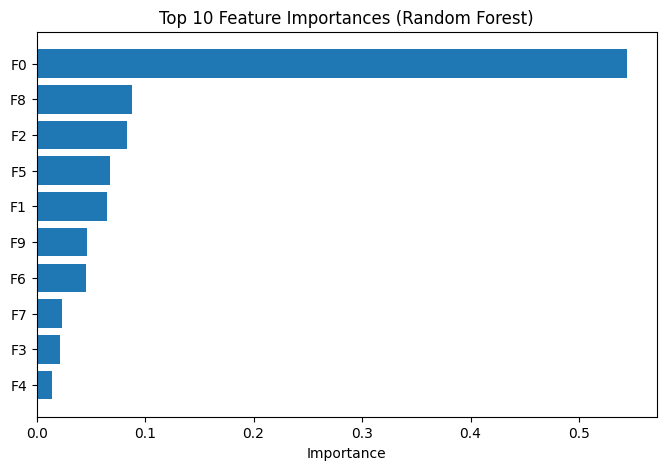

In [20]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[-10:]
plt.figure(figsize=(8,5))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [f"F{i}" for i in indices])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()


In [21]:
"""## 💾 Save Trained Models & Summary
Each model is saved with version & timestamp.
"""

'## 💾 Save Trained Models & Summary\nEach model is saved with version & timestamp.\n'

In [22]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

joblib.dump(logreg, f"artifacts/models/flow_logreg_{timestamp}.joblib")
joblib.dump(rf, f"artifacts/models/flow_rf_{timestamp}.joblib")
joblib.dump(iforest, f"artifacts/models/flow_iforest_{timestamp}.joblib")

print("✅ Models saved to artifacts/models/")


✅ Models saved to artifacts/models/


In [23]:
summary = {
    "timestamp": timestamp,
    "dataset_size": len(X),
    "models_trained": list(results.keys()),
    "metrics": results,
}

with open("artifacts/training_summary.json", "w") as f:
    json.dump(summary, f, indent=4)

print("📄 Training summary saved → artifacts/training_summary.json")


📄 Training summary saved → artifacts/training_summary.json


In [24]:
"""## 🏁 Notebook Summary

You have successfully:
- Trained 3 lightweight flow-level models  
- Evaluated precision, recall, F1, and AUC  
- Visualized key feature importances  
- Saved model artifacts and evaluation summary  

**Next:**  
➡️ Proceed to [04_packet_level_model_training.ipynb](04_packet_level_model_training.ipynb)

**Artifacts Created:**
- `artifacts/models/flow_logreg_*.joblib`
- `artifacts/models/flow_rf_*.joblib`
- `artifacts/models/flow_iforest_*.joblib`
- `artifacts/training_summary.json`
"""

'## 🏁 Notebook Summary\n\nYou have successfully:\n- Trained 3 lightweight flow-level models  \n- Evaluated precision, recall, F1, and AUC  \n- Visualized key feature importances  \n- Saved model artifacts and evaluation summary  \n\n**Next:**  \n➡️ Proceed to [04_packet_level_model_training.ipynb](04_packet_level_model_training.ipynb)\n\n**Artifacts Created:**\n- `artifacts/models/flow_logreg_*.joblib`\n- `artifacts/models/flow_rf_*.joblib`\n- `artifacts/models/flow_iforest_*.joblib`\n- `artifacts/training_summary.json`\n'

In [25]:
print("✅ Flow-level baseline training complete. Proceed to 04_packet_level_model_training.ipynb.")


✅ Flow-level baseline training complete. Proceed to 04_packet_level_model_training.ipynb.
